In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load data from Google Spreadsheet
SHEET_ID = '1JDNv_mArl-GPIpxuWS5GxgVEwvjXocS1MrXGc6TYs8M'
SHEET_NAME = ['USD/IDR', 'EUR/IDR', 'JPY/IDR']

2023-06-11 21:35:10.527863: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-11 21:35:10.750500: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 21:35:11.683476: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME[0]}'
data = pd.read_csv(url)

# Drop unused columns
data = data.drop('Unnamed: 2', axis=1)

# Convert Date columns to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y %H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1247 non-null   datetime64[ns]
 1   Close   1247 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.6 KB


In [3]:
data = data.groupby([pd.Grouper(key='Date', freq='D')]).first().reset_index()
data = data.set_index('Date')

In [4]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define the number of previous time steps to consider for forecasting
n_steps = 30

# Split the data into input (X) and output (y) sequences
X, y = [], []
for i in range(n_steps, len(scaled_data)):
    X.append(scaled_data[i - n_steps:i])
    y.append(scaled_data[i])

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [8]:
X_train.shape

(973, 30, 1)

In [9]:
# Step 2: Build and train the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_steps, X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

2023-06-11 21:38:00.452474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-11 21:38:00.454118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-11 21:38:00.455173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
# Step 3: Make predictions for future time steps
future_steps = 30  # Number of time steps to forecast into the future
last_sequence = X_test[-1]  # Get the last sequence from the testing data

predictions = []
for _ in range(future_steps):
    prediction = model.predict(np.array([last_sequence]))  # Predict the next time step
    predictions.append(prediction)
    last_sequence = np.concatenate((last_sequence[1:], prediction), axis=0)

predictions = np.array(predictions)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

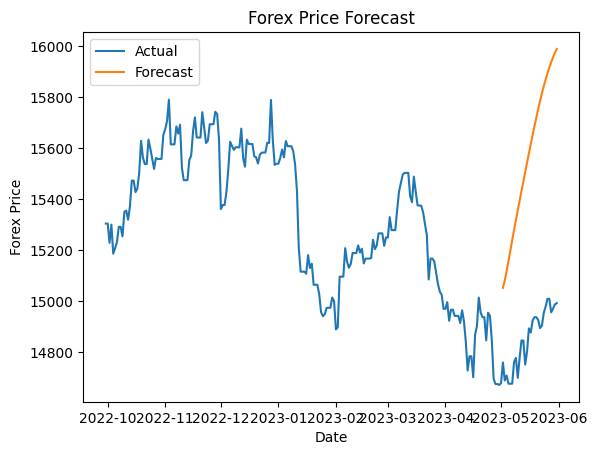

In [11]:
# Step 4: Generate a forecasting chart
plt.plot(data.index[-len(y_test):], scaler.inverse_transform(y_test), label='Actual')
plt.plot(data.index[-len(predictions):], predictions, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Forex Price')
plt.title('Forex Price Forecast')
plt.legend()
plt.show()